In [39]:
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from utils import *
from datetime import datetime

#sklearn tools and models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import xgboost as xgb

# Data loading

I'll load the data from the csv file and check the first 10 rows to get a basic notion about the data itself before start working on it.


In [3]:
data_path = './data/dataset_SCL.csv'
df = pd.read_csv(data_path)

/var/folders/5s/vdx10l697jb5phtp2_z31l8m0000gn/T/ipykernel_71917/604993815.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [3]:
df.head(10)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
5,2017-01-06 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 00:04:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
6,2017-01-07 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 23:25:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
7,2017-01-08 23:30:00,226,SCEL,KMIA,AAL,2017-01-08 23:25:00,226,SCEL,KMIA,AAL,8,1,2017,Domingo,I,American Airlines,Santiago,Miami
8,2017-01-09 23:30:00,226,SCEL,KMIA,AAL,2017-01-10 00:10:00,226,SCEL,KMIA,AAL,10,1,2017,Martes,I,American Airlines,Santiago,Miami
9,2017-01-11 23:30:00,226,SCEL,KMIA,AAL,2017-01-12 00:39:00,226,SCEL,KMIA,AAL,12,1,2017,Jueves,I,American Airlines,Santiago,Miami


## Quick data check

I want to check the data types after the dataset import as well as know how many rows the dataset has. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


# Exploration data analysis (EDA)

Before answer the first question, I'd like to know about the data, min and max values for the numeric features. On the other hand which values the categoricals feature takes.

The first actions is check how many null values the features have. With this information in mind we can take actions like try to fill the null values from a particular feature. The filling process could be for example take the most common value and fill with it, or and average of all the value if the feature is numeric.


In [5]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

As we can see the feature **Vlo-O** is the only one that has null values. Due to it just has one null value we don't lose information if we drop out these row. Also, in the previous step we can see that the dataset has **68206 rows**, so we won't lose much data. Hence I will to procede to delete it.

In [4]:
# droping the missing value
df = df.dropna()

### Checking the Date feature

At first glance looking for the min and max date in **Fecha-I** (flight schedulled date and time) I realized that all the dataset rows are for the same year, 2017.
But I do a cross validation checking the column Año. There I saw that there are two year 2017 and 2018. 

Filtering the date with the new discovered year we just get two rows. Moreover if we see these filtered row, we will discover that the two flights were operated in the new years. So this new year value cann't affect the analysis and future predictions.

In [7]:
f"Minimun date in the dataset {df['Fecha-I'].min()}. Max date in the dataset {df['Fecha-I'].max()}"

'Minimun date in the dataset 2017-01-01 00:15:00. Max date in the dataset 2017-12-31 23:55:00'

In [8]:
f"Different years in the AÑO feature: {df['AÑO'].unique()}"

'Different years in the AÑO feature: [2017 2018]'

In [9]:
df[df['AÑO'] == 2018]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


### Plotting data
Let's a graphical interpretation of the data and what the data can tell about it.

We'll see severl graph that aims to undercover the underlying information

<AxesSubplot:title={'center':'Most operated Airline'}, xlabel='count', ylabel='OPERA'>

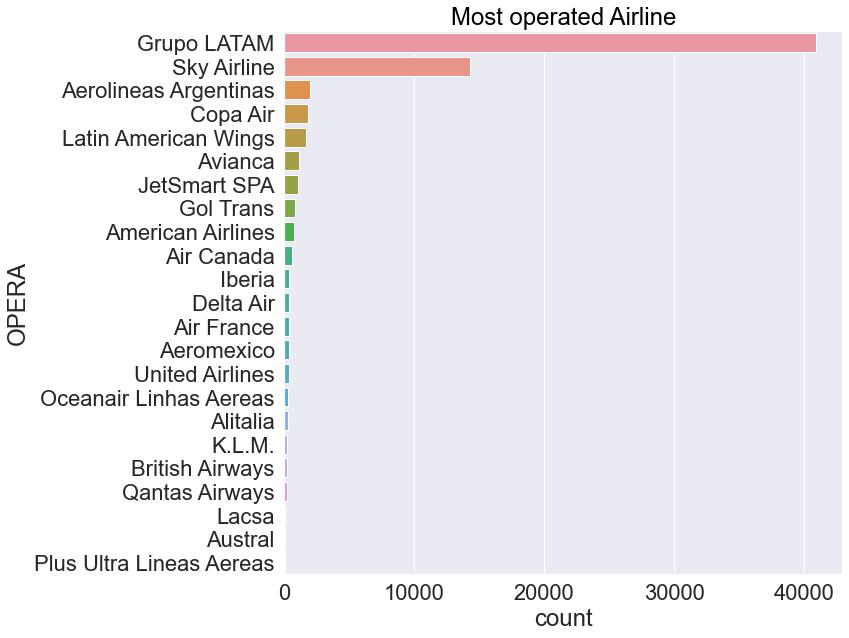

In [134]:
fig = plt.figure(figsize=(10, 10))
plt.title('Most operated Airline')
seaborn.countplot(y=df['OPERA'], order=df.OPERA.value_counts().index)

Due to Grupo LATAM has the most number of operation, I'll check how many company operate by this group and if there are more groups.

Below we see that Grupo LATAM has 7 arline company. Also we can see an small group, Latin American Wings, with two airlines.
Because we can assume that the **OPERA** column is a generalization and the **Emp-I** will provide redudant data to the future model we can delete Emp-I witout lose information.

In [11]:
for o in df.OPERA.unique(): 
    tmp = df[df.OPERA==o]
    if len(tmp['Emp-I'].unique())>1:
        print(f'Group: {o}')
        print(f">>>Airlines: {tmp['Emp-I'].unique()}")

Group: Grupo LATAM
>>>Airlines: ['LAP' 'TAM' 'LAN' 'LXP' 'LNE' 'LPE' 'DSM']
Group: Latin American Wings
>>>Airlines: ['LAW' 'JMR']


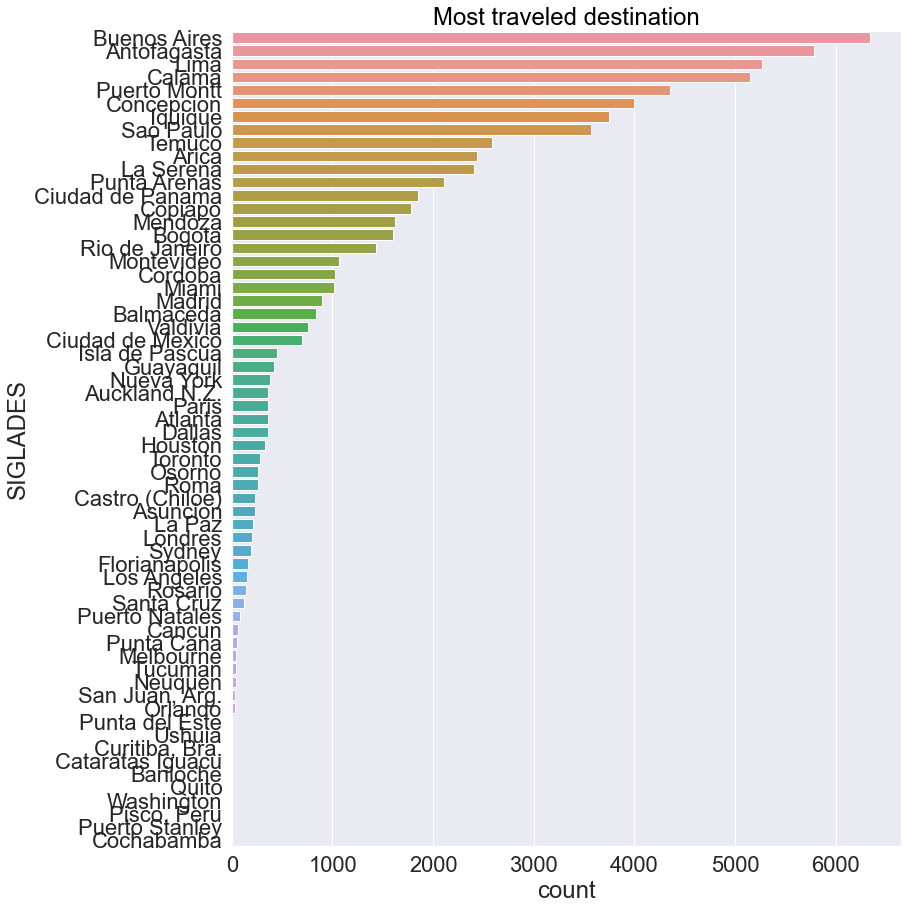

In [142]:
fig = plt.figure(figsize=(12, 15))
seaborn.countplot(y=df['SIGLADES'],  order=df.SIGLADES.value_counts().index)
plt.title('Most traveled destination')
plt.tick_params(labelrotation=0)

Text(0.5, 1.0, 'Amount of international and national flight')

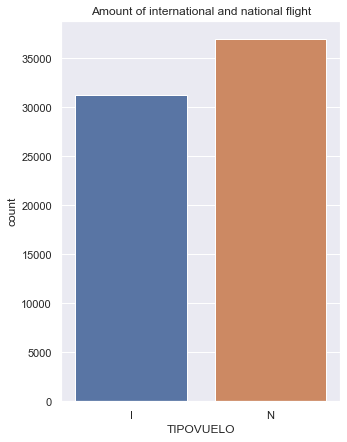

In [209]:
fig = plt.figure(figsize=(5, 7))
seaborn.countplot(x=df['TIPOVUELO'])
plt.title('Amount of international and national flight')

/var/folders/5s/vdx10l697jb5phtp2_z31l8m0000gn/T/ipykernel_66849/56111283.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


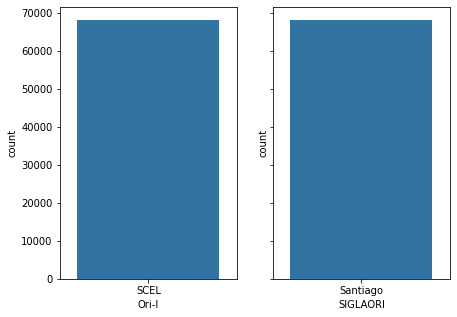

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,5), sharey='row')
seaborn.countplot(x=df['Ori-I'], ax=ax[0])
seaborn.countplot(x=df['SIGLAORI'], ax=ax[1])

fig.show()

## Answer 1

I took the data and I learnt about the dataset without taking into account the target column. Because it's possible to get knowdledge and notion regardless the target.

### First Conclusions

These dataset present flights between Junary and December of 2017. Also the data shows the next insights: 
* The most operated airles are part of Grupo Latam and Sky Airlines with at least 10000 opeartions. There are a few companies with at most 2500 opeartions.
* All the departures start from SCEL aiport (Santiago de Chile) thereby the predictions of the model will be related (or biased) from this departure city.

This insight are important because we can see that the dataset is biased or disvalanced realted to the departure airport as well as with the airlines that operate the flights. But we cann't assume in this instance that the delays is due to these airlines.

A deep analysis will be do after achive the next step getting the delay column. And we can show the distrubution of the data based on the target as well as answer questions like:
* Are there more delays on international or national flights?
* What is the proportion between on time and delayed flights?
* There is a correlation between a period of the day and the delay?

# Data transformation

In this section, I'll create the new columns and later save them into a new csv file. The code related to the column creation can be checked inside the **utilis.py** file.

In [5]:
df['temporada_alta'] = df.apply(lambda x: is_high_season(x), axis=1)

/Users/nestornav/dev/me/test/assestments/ml_airplane_delay/utils.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if (now_date >= pd.to_datetime('2017-12-15') and now_date <= pd.to_datetime('2017-12-31'))\
/Users/nestornav/dev/me/test/assestments/ml_airplane_delay/utils.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  or (now_date >= pd.to_datetime('2017-01-01') and now_date <= pd.to_datetime('2017-03-03'))\
/Users/nestornav/dev/me/test/assestments/ml_airplane_delay/utils.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard lib

In [6]:
df['dif_min'] = df.apply(lambda x: flight_delay(x), axis=1)

/var/folders/5s/vdx10l697jb5phtp2_z31l8m0000gn/T/ipykernel_71917/1966043647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif_min'] = df.apply(lambda x: flight_delay(x), axis=1)


In [7]:
df['atraso_15'] = df.apply(lambda x: has_delay(x), axis=1)

/var/folders/5s/vdx10l697jb5phtp2_z31l8m0000gn/T/ipykernel_71917/3990148637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atraso_15'] = df.apply(lambda x: has_delay(x), axis=1)


In [8]:
df['periodo_dia'] = df.apply(lambda x: get_day_period(x), axis=1)

### Saving the features
The cell bellow will dump the new created features into the data directory. Using the **path** variable, you can customize the place where you can save the data without modify the other part of the code.

In [20]:
path = './data/synthetic_features.csv'
dump_data(df, path)

# Delay time analysis
With the new data created I will analyze the delay and how it is related to others features. First of all I want to check the proportion of on time and delayed flights.

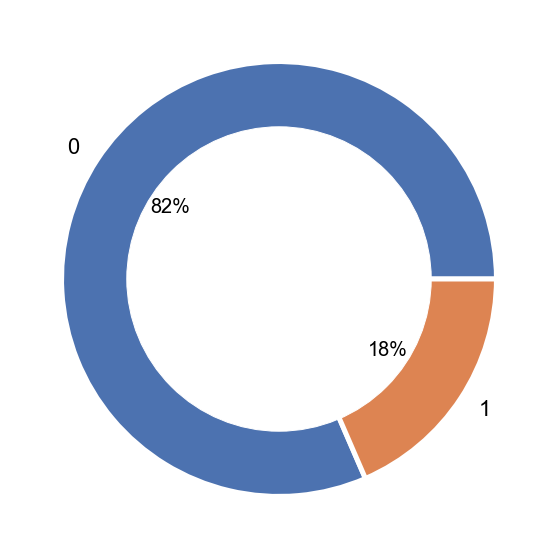

In [17]:
pie_plot(df)

Surprisingly the proportions of delayed flight is less than 20% of the total of the flights in the 2017 year.

Now, I'd like to know how the delay time distribution behave.

Text(0.5, 8.95999999999998, 'Delay (mins)')

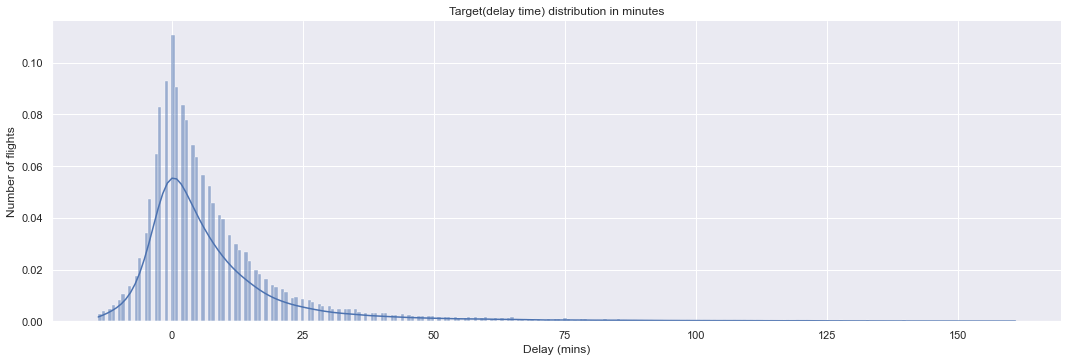

In [19]:
seaborn.displot(data=df, x=df['dif_min'], aspect=3, kde=True, stat='density') 
plt.ticklabel_format(style='plain', axis='x')
seaborn.set(font_scale = 1)
plt.title('Target(delay time) distribution in minutes')
plt.ylabel('Number of flights')
plt.xlabel('Delay (mins)')

As can see, the distribution is centered around zero with a long tail to the right. There a several values after the fifty minutes of delay. This outliers values need to be evaluated more further to identify the possible reason because they can cause some issues in the predictions.

<Figure size 1440x1440 with 0 Axes>

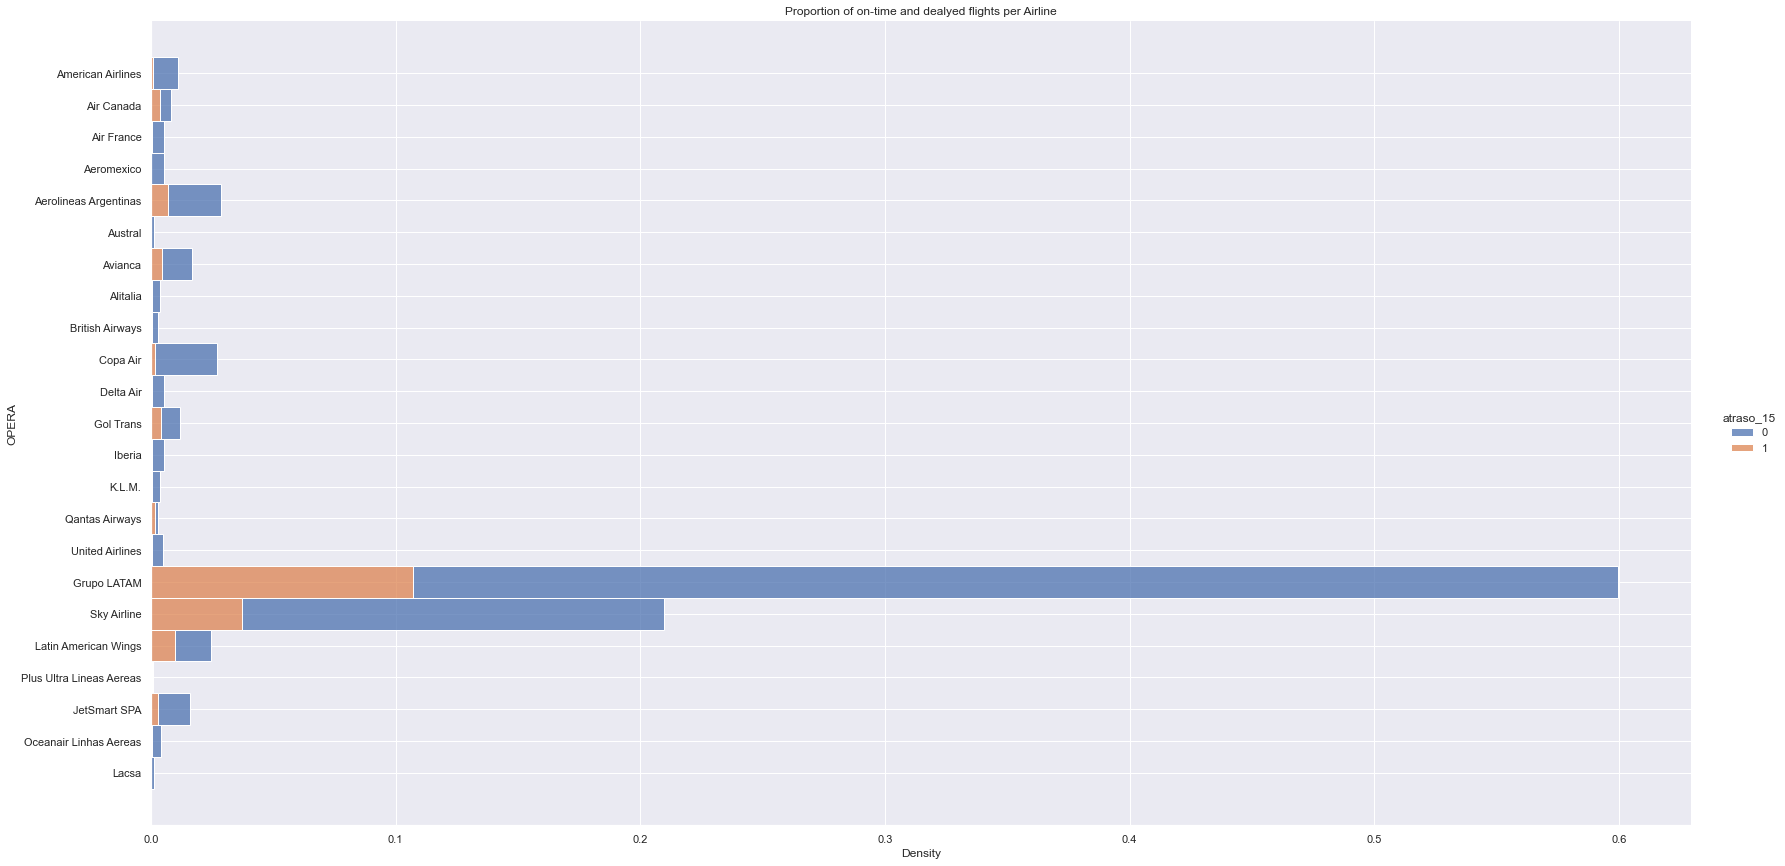

In [20]:
stack_plot(df)

In [120]:
total_1_latam = df[df['OPERA'] == 'Grupo LATAM'].groupby('atraso_15').count()['OPERA'][1]
total_latam = df[df['OPERA'] == 'Grupo LATAM'].count()['atraso_15']

total_1_sky = df[df['OPERA'] == 'Sky Airline'].groupby('atraso_15').count()['OPERA'][1]
total_sky = df[df['OPERA'] == 'Sky Airline'].count()['atraso_15']

print(f"Delay proportion for Grupo LATAM: {total_1_latam/total_latam}")
print(f"Delay proportion for Sky Airlines: {total_1_sky/total_sky}")

Delay proportion for Grupo LATAM: 0.17866575369265383
Delay proportion for Sky Airlines: 0.1776472233878864


Here is even more clear that the delay is not a common issue for the major of the airlines. To the most busiest airlines (Latam and Sky) they have almost equal delay portion arount the **0,17** as we can see above. 

Without a business eye this result maybe we can avoid the cost to implement a machine learning model to predict the delay. But an interesting analysis could be how the delay proportion impact in business metrics such as GMV, or customer satisfaction. If the impact of the delay is considerable or even huge, the ROI of a machine learning model implementation is high.

Text(0.5, 1.0, 'Proportion of delay by destination')

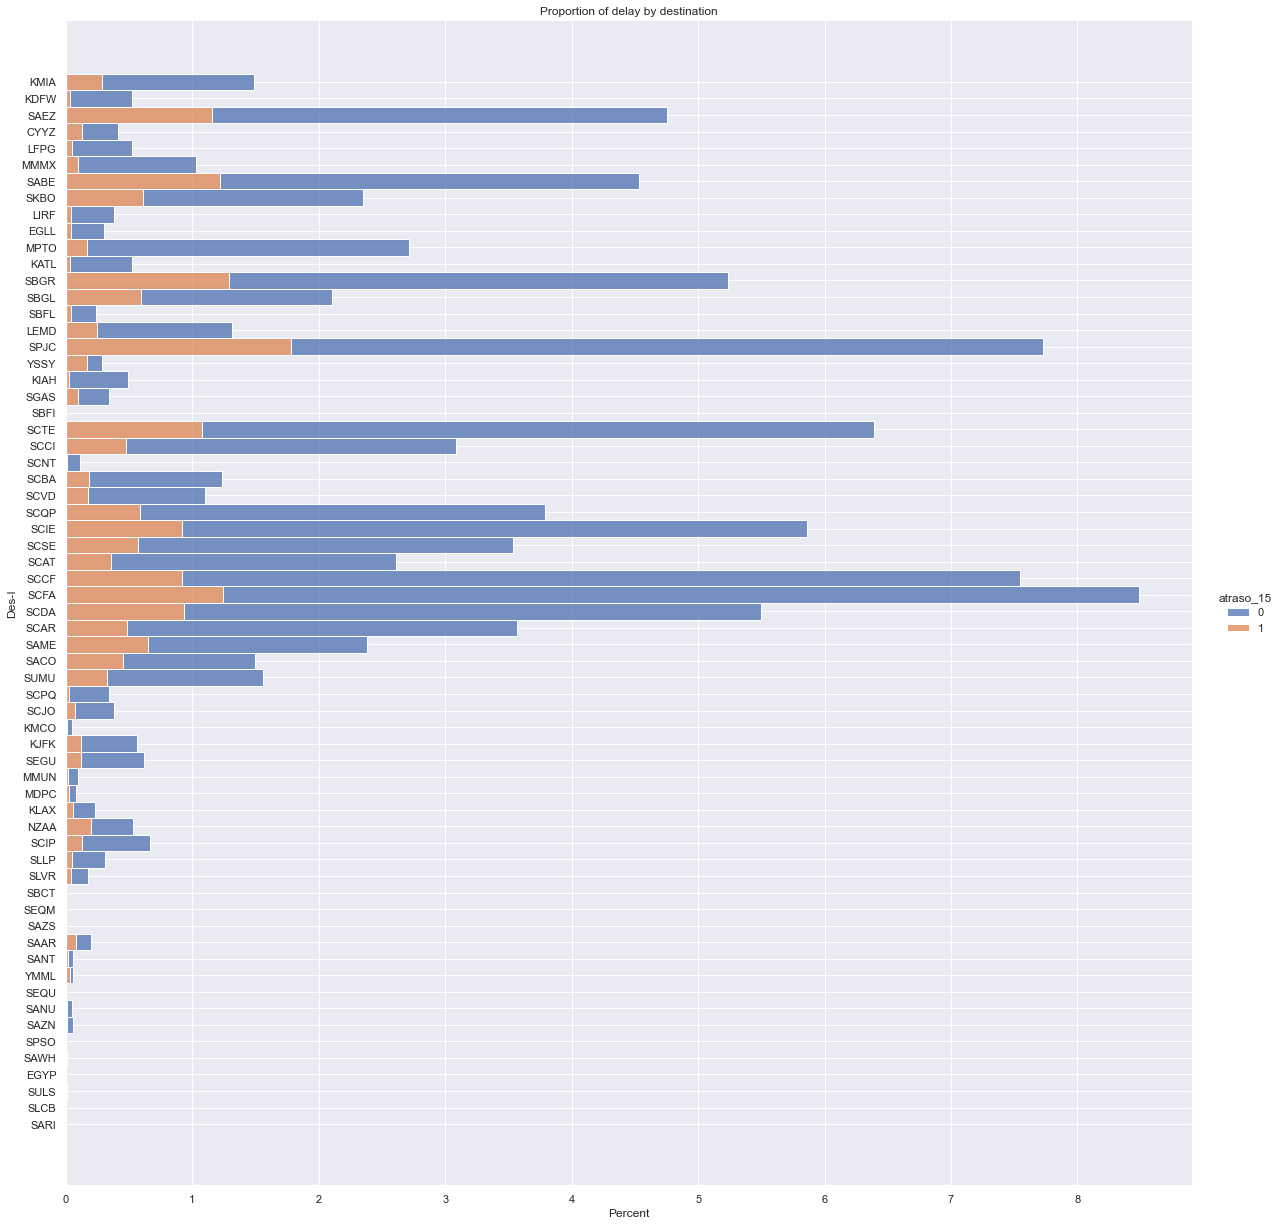

In [21]:
seaborn.set(font_scale = 1)
seaborn.displot(data=df, y='Des-I', hue='atraso_15', multiple="stack", height=17,stat='percent')
plt.tick_params(labelrotation=0)
plt.title('Proportion of delay by destination')

In [249]:
for s in df.SIGLADES.unique(): 
    tmp = df[df.SIGLADES==s]
    if len(tmp['Des-I'].unique())>1:
        print(f'City: {s}')
        print(f">>>Airports: {tmp['Des-I'].unique()}")

City: Miami
>>>Airports: ['KMIA' 'KJFK']
City: Buenos Aires
>>>Airports: ['SAEZ' 'SABE' 'SEGU']
City: Rio de Janeiro
>>>Airports: ['SBGL' 'SBGR']
City: Cataratas Iguacu
>>>Airports: ['SBFI' 'SARI']
City: Puerto Montt
>>>Airports: ['SCTE' 'SCBA' 'SCCI' 'SCIE']
City: Punta Arenas
>>>Airports: ['SCCI' 'SCTE']
City: Temuco
>>>Airports: ['SCTE' 'SCQP' 'SCIE']
City: Calama
>>>Airports: ['SCCF' 'SCFA']
City: Quito
>>>Airports: ['SEQM' 'SEQU']
City: Melbourne
>>>Airports: ['YMML' 'YSSY']


There are city with more than airport code. There are a few cities like Calama or Buenos Aires with delay rates around the 15%. Moreover the most delayed flights are concentrated in Latin America.

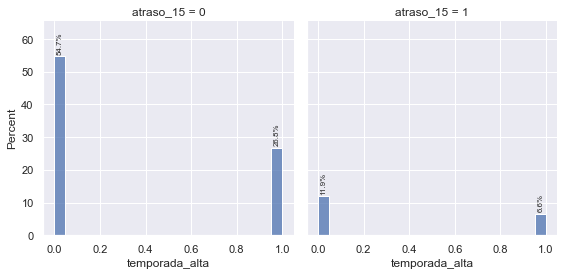

In [22]:
fg = seaborn.displot(data=df, x='temporada_alta', stat='percent', col='atraso_15', height=4, aspect=1)
seaborn.set(font_scale =1)

for ax in fg.axes.ravel():
    for c in ax.containers:
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)
    ax.margins(y=0.2)
plt.show()

As we can see, for high season the delayed flights are less tan the ~9%. We have more delay on regular season than in high season.

## Period of time analysis

Let's see how the delays behave by day and month.

Text(0, 0.5, 'Delay in min')

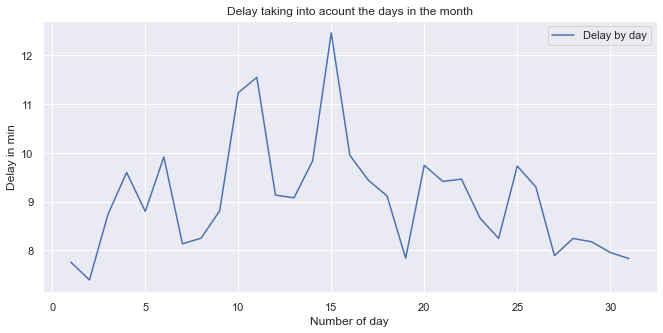

In [23]:
plt.figure(figsize=(11,5))
seaborn.lineplot(data=df.groupby('DIA').mean()['dif_min'], label='Delay by day')
seaborn.set(font_scale = 1)
plt.title('Delay taking into acount the days in the month')
plt.xlabel('Number of day')
plt.ylabel('Delay in min')

The delay is higher in in the middle of the month between the 10th and 15th. But the behavior is erratic and hard to understand the reason with the current data.

Text(0, 0.5, 'Delay in min')

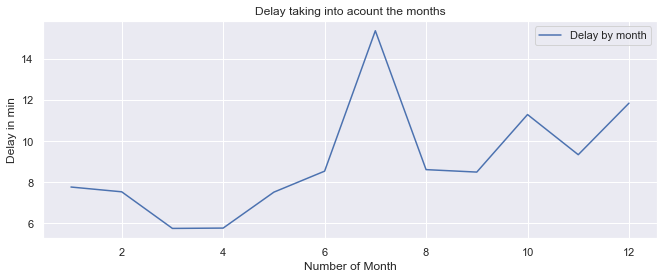

In [24]:
plt.figure(figsize=(11,4))
seaborn.lineplot(data=df.groupby('MES').mean()['dif_min'], label='Delay by month')
seaborn.set(font_scale = 1)
plt.title('Delay taking into acount the months')
plt.xlabel('Number of Month')
plt.ylabel('Delay in min')

As can see, in July there is a peak in delays. This peak could be affected by a seasonality events like winter holidays. Then from September until the end of the year the delay increse but under the 15 minutes.


Text(0.5, 1.0, 'Mean of delayed flight by day')

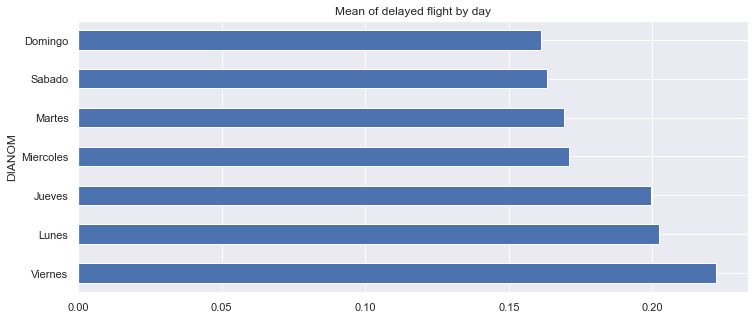

In [25]:
df.groupby('DIANOM').mean()['atraso_15'].sort_values(axis=0,ascending=False).plot.barh(figsize=(12,5))
plt.title('Mean of delayed flight by day')

Text(0.5, 1.0, 'Number of flight by day period')

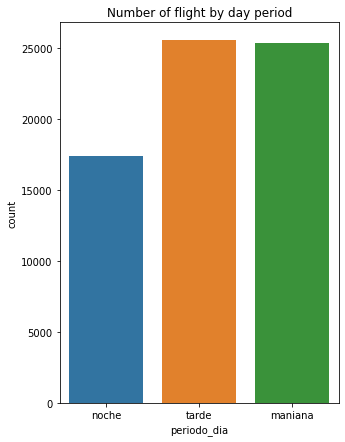

In [10]:
fig = plt.figure(figsize=(5, 7))
seaborn.countplot(x=df['periodo_dia'])
plt.title('Number of flight by day period')

The chart show us that during the night time the numbler of flight is low compared to the morning and afternoon.

## Answer 3

In the analysis we can see that the delay for a whole year (2017) is the 18%. Also we check that the most delyead airlines are Grupo LATAM and with almost the 80% of the total of flights.
At first glance we can think that this 18% of is not so much. But we need understand how this delay rate impact on business metric presented above such as the GMV for those company.

### Understanding the flights delay

As we know, all the flights departure are from Santiago de Chile(SCEL). With this information in mind, we see that in July there is a peak in the fligths delay. We can think some hypothesis related to winter holidays (increase the number of people interested to flight) or some weather conditions issues(snow storm cann't allow to take off an airplane). Also the delay is strong on Fridays as well as on Monday and Thurdays. This situation is well know because a lot of people or familis take some weekends breaks. An interesting analysis could be how national holidays in Chile affect the delay in days like Friday.

The destination is something to take into account to the prediction. Because there are flights to cities like Buenos Aires or Quito with high rates of delay. The Migration process add an extra time for travelers but it's compensated arriving early to airport. Also Antofagaste (local flight) has a interesting delay rates.

# Model definition

Before train a model I will prepare the categorical data, remove current features with less significance or redudant data. Split the dataset in trainning and test dataset. Finally train and measure the performance of them.

The categorical variable need to be transformed to numbers but isn't necessary feature engineering like stopwords filtering and so on because there aren't a los of text to work.

In [9]:
colums_to_drop = columns=['dif_min','Fecha-I','Emp-I','Ori-I','Vlo-O','Ori-O', 'Des-O',
                          'Emp-O','Fecha-O', 'AÑO', 'SIGLAORI', 'atraso_15', 'temporada_alta']

categorical_features = ['Vlo-I', 'Des-I','DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES','periodo_dia']

data = df.drop(colums_to_drop, axis='columns')
target = df['atraso_15']

In [10]:
data.head(2)

,Vlo-I,Des-I,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,periodo_dia
0,226,KMIA,1,1,Domingo,I,American Airlines,Miami,noche
1,226,KMIA,2,1,Lunes,I,American Airlines,Miami,noche


In [24]:
# From now the model will be ingested with a same kind of data
df_encoded = pd.get_dummies(data=data, columns=categorical_features)
df_encoded = df_encoded.loc[:,~df_encoded.columns.duplicated()]

In [25]:
# Now I'll slpit both data trainning and target(atraso_15).
# The splitting data is needed to avoid issues like overfitting
# Also we set up a seed, this value allow us to create the same sampling in the feature.

X_train, X_test, y_train, y_test = train_test_split(
    df_encoded,
    target,
    test_size=0.1,
    random_state=0,
)

## Answer 4/5 part I
I'll train two models, an Stochastic Gradient Descent Classifier and XGBoost.

### Why this models?
The next sections I'll try to share my point of view about the selection. There a bias related to my personal point of view based on my experience. One of this reason is for a proof of concept or first iteration about a problem the best, is keep simple the process. Learn about the data in a model, improve it and then go for a more complex solution. This kind of itreation save time and money as well as maximize the data science time.

#### SGD Classifier
Stochastic Gradient Descent is a simplier and powerfull optimization algorithm used in a wide range of method even deep learning libraries such as Pytorch.
It's is simple model to start working and provide different cost funtion to apply and evalute.

#### XGBoost
This algorithms had excelente results in a lot of Kaggle competitions, and in both academy and industry projects. It's a strong choice to start with a base model, it's light, a good trade of at trainning time and for supervised projects perform really well.


## SGDClassifier

In [44]:
# Define the hyperparams to the model
max_iter = 1000
tol=1e-3
penalty = "elasticnet"

In [40]:
SGDclf = SGDClassifier(max_iter=max_iter, tol=tol, penalty=penalty)
SGDclf.fit(X_train, y_train)

SGDClassifier(penalty='elasticnet')

In [42]:
y_pred = SGDclf.predict(X_test)

## XGboost

In [ ]:
model_hparams = {"max_depth": 7, "learning_rate" : 0.01, "num_leaves": 120,  "n_estimators": 1000}

In [27]:
xg_boost = xgb.XGBClassifier()
xg_boost.fit(X_train,y_train)

[20:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
y_pred = xg_boost.predict(X_test)

In [29]:
result=xg_boost.predict_proba(X_test)

In [33]:
print(round(precision_score(y_test,y_pred),2))
print(round(recall_score(y_test,y_pred),2))


0.61
0.11


## Answer 4/5 part II

### Performance


### How can I improve the model?

A possible improve could be create an ensabled (train two different algorithms, where the output of one is the input of the other). This kind of technichs improve really well the performance of the model. XGBoost perform really well in this kind of method and it's another point for their selection.

Nowadays there are a few technics that focus not the hyperparams of the model to improve the model. This technics look for to understand a trainned model based on how the current features have incidences into the predictions itselft.

For example a validad question is: *What features have the biggest impact on predictions?*. To answer this question we can use the **feature importance** analyzis. The main idea is assing an score for the features based on their importance to predict the output.

For this task we can use Permutation importance or Shap Values to get more insight about our model and do improvements on it.